In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = 'smoke_detection_iot.csv'

data = pd.read_csv(path)

Y_df = data['Fire Alarm']
X_df = data.drop(['Fire Alarm'], axis=1)

X = X_df.values
Y = Y_df.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = [LogisticRegression(), GaussianNB(), SVC(kernel='linear'), SVC(kernel='rbf')]

c:\Users\super\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\super\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

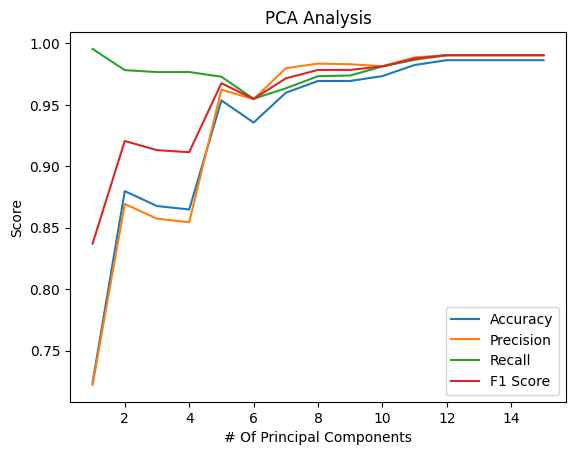

Max precision at K = 12; 0.9903609056265411
Max accuracy at K = 12; 0.9863483953376976
Max recall at K = 1; 0.9955161977356799
Max F1 Score at K = 12; 0.9904164097965588


In [21]:
K = X_train.shape[1]
datasets = np.zeros(K+1, dtype=object)
results = np.zeros((K, Y_test.shape[0]))
accuracy_hist = np.zeros(K)
precision_hist = np.zeros(K)
recall_hist = np.zeros(K)
f1_hist = np.zeros(K)

for k in range(1,K+1):
    extraction = PCA(n_components=k)  
    X_train_pca = extraction.fit_transform(X_train)
    X_test_pca = extraction.transform(X_test)
    
    datasets[k-1] = (X_train_pca, X_test_pca)
    
    model = LogisticRegression().fit(X_train_pca, Y_train)
    
    Y_pred = model.predict(X_test_pca)
    
    accuracy_hist[k-1] = accuracy_score(Y_test, Y_pred)
    precision_hist[k-1] = precision_score(Y_test, Y_pred)
    recall_hist[k-1] = recall_score(Y_test, Y_pred)
    f1_hist[k-1] = f1_score(Y_test, Y_pred)
    results[k-1] = Y_pred
    
K = range(1,k+1)
plt.title("PCA Analysis")
plt.xlabel("# Of Principal Components")
plt.ylabel("Score")
plt.plot(K,accuracy_hist, label='Accuracy')
plt.plot(K,precision_hist, label = 'Precision')
plt.plot(K,recall_hist, label = 'Recall')
plt.plot(K,f1_hist, label = 'F1 Score')

plt.legend()
plt.show()
print(f'Max precision at K = {np.argmax(precision_hist)+1}; {max(precision_hist)}')
print(f"Max accuracy at K = {np.argmax(accuracy_hist)+1}; {max(accuracy_hist)}")
print(f"Max recall at K = {np.argmax(recall_hist)+1}; {max(recall_hist)}")
print(f"Max F1 Score at K = {np.argmax(f1_hist)+1}; {max(f1_hist)}")
    
    




In [22]:
X_train_pca = datasets[11][0]
X_test_pca = datasets[11][1]